# Monitoring
### In this module we will discuss monitoring which differs than evaluation module.
### In this module, we evluate the entire RAG pipeline to ensure that the system works as we expect.
### In the evaluation module, we tested only that the Retrival part is working good.

## In this module we mainly conisder offline monitoring which means before production.

# 1. Cosine Similarity

## Load documents with IDS

In [31]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from openai import OpenAI
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer

In [4]:
# Loading the documents. remeber this was the initial dataset we have that
# has all the "answers" that we used to generate 5 Qs per answer to have 
# the ground truth dataset that we evaluate upon
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [5]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth dataset

In [6]:
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [7]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [8]:
# for the documents data (not the ground truth) we are generating a dic
# id:doc
doc_idx= {doc['id']: doc for doc in documents}
doc_idx['5170565b']['text'] # the answer

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index the data

Run this command in your terminal to set up elastic search in docker to help us connect to elastic search locally:

docker run -it \
  --rm \
  --name elasticsearch \
  -p 9200:9200 \
  -p 9300:9300 \
  -e "discovery.type=single-node" \
  -e "xpack.security.enabled=false" \
  docker.elastic.co/elasticsearch/elasticsearch:8.4.3

In [9]:
# Initalize the embedding model
model_name ='multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [10]:
# Initalize the vector DB
es_client= Elasticsearch('http://localhost:9200')

In [11]:
# set the mapping
index_settings= {
    "settings":{
        "number_of_shards":1,
        "number_of_replicas":0
    },
    "mappings":{
        "properties":{
            "text":{"type":"text"},
            "section":{"type":"text"},
            "question":{"type":"text"},
            "course":{"type":"keyword"},
            "id":{"type":"keyword"},
            "question_text_vector":{"type":"dense_vector",
                          "dims":384,
                          "index":True,
                          "similarity":"cosine"},
        }
    }  
}

In [13]:
# create the index after we have created the mapping 
index_name = "course-questions"
es_client.indices.delete(index = index_name , ignore_unavailable=True) # delete index if it exists  
es_client.indices.create(index = index_name , body= index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [11]:
# create embeddings for the data & put it in the db
for doc in tqdm(documents):
    question_text= doc['question'] +' '+doc['text']
    doc['question_text_vector']= model.encode(question_text)
    es_client.index(index= index_name, document=doc)

100%|████████████████████████████████████████| 948/948 [01:16<00:00, 12.31it/s]


## Retrieval

In [14]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [15]:
def question_vector_knn(q,field='question_text_vector'):
    question = q['question']
    course= q['course']

    embeddings= model.encode(question)
    return elastic_search_knn(field=field, 
                   vector= embeddings,
                   course=course)

In [16]:
question_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[]

## RAG Flow {from module1}

In [15]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [16]:
def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [17]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    # This gets the search results that will be a context after formualtion
    search_results = question_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [18]:
OPENAI_API_KEY=""
client = OpenAI(api_key=OPENAI_API_KEY)

In [19]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [20]:
rag_answ=rag(ground_truth[10])

In [21]:
rag_answ

'Yes, sessions are recorded if you miss one. You can catch up on the recorded sessions and ask questions in advance for office hours or in Slack.'

In [22]:
orginal_answ=doc_idx["5170565b"]["text"] # the correct answer

### Cosine Similiarity

In [23]:
rag_vector=model.encode(rag_answ)
original_vector=model.encode(orginal_answ)
rag_vector.dot(original_vector)

0.63458365

In [26]:
answers={}

In [ ]:
# We will now do that on the entire dataset
# 1. we will go through the entire ground truth dataset questions 
# 2. generate answer using llm 
# 3. compute the cos sim between rag_answ & the documents that has the correct answer
# will not run this cell as not to pay for open ai & use the one generated from the course 
# He saved it in a file called results-gpt4o.csv that we will need to load it 
# if we want to use it 
# he also generated one wfor gpt-3.5
for i,record in enumerate(ground_truth):
    # inorder not to recalculate it if there is any error that occurred
    if i in answers:
        continue 
    # answer_llm = rag(record)
    # indexing the dictionary with the doc_id and getting the document text
    id=record['document']
    answer_original = doc_idx[id]['text']
    answers[i]={
        "answer_llm":answer_llm,
        "answer_original":answer_original,
        "document": id,
        'question': rec['question'],
        'course': rec['course'],
    }

# Starting Offline Evaluation
## GPT4O

In [17]:
df_gpt4o=pd.read_csv("data/results-gpt4o.csv")

In [18]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [19]:
# turn it into dictionary
results_gpt4o=df_gpt4o.to_dict(orient='records')

In [20]:
def compute_cos_similarity(record):
    answer_llm=record['answer_llm']
    answer_orig=record['answer_orig']

    v_llm=model.encode(answer_llm)
    v_orig=model.encode(answer_orig)

    return v_llm.dot(v_orig)

In [21]:
similarity=[]

for record in tqdm(results_gpt4o):
    sim=compute_cos_similarity(record)
    similarity.append(sim)

100%|██████████████████████████████████████| 1830/1830 [02:55<00:00, 10.40it/s]


In [22]:
df_gpt4o['cosine']= similarity

In [23]:
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

## GPT3.5

In [28]:
df_gpt35=pd.read_csv("data/results-gpt35.csv")
results_gpt35=df_gpt35.to_dict(orient='records')

similarity=[]

for record in tqdm(results_gpt35):
    sim=compute_cos_similarity(record)
    similarity.append(sim)

df_gpt35['cosine']= similarity

100%|█████| 1830/1830 [02:13<00:00, 13.72it/s]


In [29]:
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

## GPT4.o-mini

In [35]:
df_gpt4omini=pd.read_csv("data/results-gpt4o-mini.csv")
results_gpt4omini=df_gpt4omini.to_dict(orient='records')

similarity=[]

for record in tqdm(results_gpt4omini):
    sim=compute_cos_similarity(record)
    similarity.append(sim)

df_gpt4omini['cosine']= similarity

100%|█████| 1830/1830 [02:29<00:00, 12.22it/s]


In [36]:
df_gpt4omini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

/tmp/ipykernel_9592/525234686.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label ='4o')
/tmp/ipykernel_9592/525234686.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label ='3.5')
/tmp/ipykernel_9592/525234686.py:3: UserWarning: 

`distplot` is 

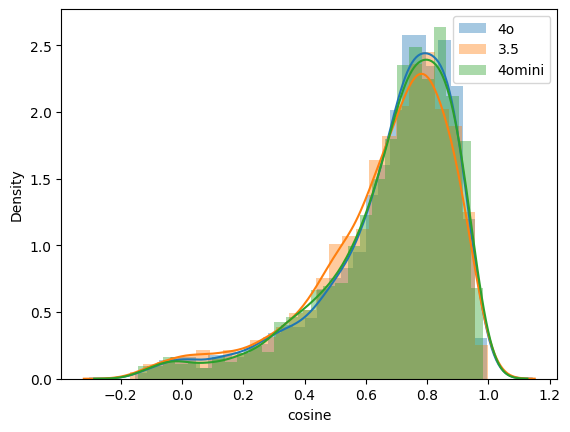

In [37]:
sns.distplot(df_gpt4o['cosine'], label ='4o')
sns.distplot(df_gpt35['cosine'], label ='3.5')
sns.distplot(df_gpt4omini['cosine'], label ='4omini')

plt.legend()

## Some info comparing three models:
1. gpt4o took ~10 \\$   & gpt3.5 took ~0.75\\$  &  gpt4omini took ~0.28 \$
2. when we ran gpt4o without parallelization it took ~3hrs , but gpt3.5 was ran threaded took ~6 mins
3. got4omini has mean (0.68) gpt4o (0.679) , gpt3.5 ( 0.65)

# 2. LLM as Judge

Instead of computing the cos similarity, we ask an llm to tell us how good the other llm answer is to the original one.

We will use two methods:
1. we have question , original answer, llm answer
2. we have question and llm answer

option 2 can be more feasible in some scenarios and can be used in Online evaluation as well. 

In [38]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()


In [39]:
# if we do not want to work on entire dataset, we can sample
df_sample = df_gpt4omini.sample(n=150, random_state=1)
samples = df_sample.to_dict(orient='records')

In [40]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.901075541973114}

In [41]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [ ]:
answer = llm(prompt, model='gpt-4o-mini')

In [ ]:
# for the enitre sampled dataset.
# will not run it but instead use the generated file from the course
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval) # parses the JSON string into a Python dictionary using 
    json_evaluations.append(json_eval)